In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# Set dataframe viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Upload cleanded data from local machine
file_path = '/Users/nickburkhalter/Desktop/mortality/'
data = '2015_data_cleaned.csv'

df = pd.read_csv(file_path + data)

In [3]:
# Create function to wrangle new features
def wrangle(X):
    
    # Make copy of X so as not to contaminate original
    X = X.copy()
    
    # Create heart_disease feature (did person die of heart disease?)
    X['heart_disease'] = (X['39_cause_recode'].str.contains('heart')) | (X['39_cause_recode'].str.contains('heart'))
    # Create feature for cancer (keyword 'malignant neoplasm')
    X['cancer'] = ((X['39_cause_recode'].str.contains('Malignant neoplasm')) | 
                   (X['39_cause_recode'].str.contains('malignant neoplasm')) | 
                   (X['39_cause_recode'].str.contains('Leukemia')))
    # Create feature for HIV
    X['hiv'] = (X['39_cause_recode'].str.contains('HIV'))
    # Create feature for suicide
    X['suicide'] = (X['39_cause_recode'].str.contains('suicide'))
    # Create feaure for homicide
    X['homicide'] = (X['39_cause_recode'].str.contains('homicide'))
    # Create feature for accidents
    X['accident'] = (X['39_cause_recode'].str.contains('accident'))
    # Create feature for Alzheimer's
    X['alzheimers'] = (X['39_cause_recode'].str.contains("Alzheimer's"))
    # Create feature for respiratory
    X['respiratory'] = ((X['39_cause_recode'].str.contains('respiratory')) | 
                       (X['39_cause_recode'].str.contains('Respiratory')))
    # Create feature for diabetes
    X['diabetes'] = (X['39_cause_recode'].str.contains('Diabetes'))
    
    # Replace 999 value for age with np.nan
    X['detail_age'] = X['detail_age'].replace(999, np.nan)
    # Fill na with mean age
    X['detail_age'] = X['detail_age'].fillna(round(X['detail_age'].mean()))
    
    # Convert our engineered features to int
    eng_feats = ['heart_disease', 'cancer', 'hiv', 'suicide', 'homicide', 
                 'accident', 'alzheimers', 'respiratory', 'diabetes']
    X[eng_feats] = X[eng_feats].astype(int)
    
    # Fill education_level NaNs with Unknown label
    X['education_level'] = X['education_level'].fillna('Unknown')
    
    # Fill activity_code NaNs with Not applicable
    X['activity_code'] = X['activity_code'].fillna('Not applicable')
    
    # Drop columns with supermajority NaNs, duplicates, and others that had < 0
    # permutation importance scores from earlier trials
    X = X.drop(columns=['place_of_injury_for_causes_w00_y34_except_y06_and_y07_', 
                        '130_infant_cause_recode', 'race_recode_3', 
                        'race_recode_5', 'age_bin', 'hispanic_originrace_recode', 
                        'day_of_week_of_death', 'detail_age_type', 'infant_age_recode_22'])
  
    # Drop 39_cause_recode column to avoid leakage
    X = X.drop(columns='39_cause_recode')
    
    return X

In [4]:
# Create wrangled dataframe
test = wrangle(df)

test.shape

(700000, 23)

In [5]:
# We will randomly split the data w/ train_test_split
# We will also include a validation set for our baseline model for quick performance

# Import the proper sklearn module 
from sklearn.model_selection import train_test_split

# Split into train & test sets first
# Seed for reproduceability
X_train, X_test = train_test_split(test, train_size=0.8, test_size=0.2, 
                                  stratify=df['sex'], random_state=42)

# Split X_train into train and val sets
# Seed for reproduceability
X_train, X_val = train_test_split(X_train, train_size=0.8, test_size=0.2, 
                                 stratify=X_train['sex'], random_state=42)

# Drop target column from train, validation, & test sets and set y target vectors for each
target = 'sex'
y_train = X_train[target]
y_val = X_val[target]
y_test = X_test[target]

X_train = X_train.drop(columns=target)
X_val = X_val.drop(columns=target)
X_test = X_test.drop(columns=target)

# REMEMBER: test set will not be used until the end!

In [6]:
# Get majority baseline
print('Train stratification:\n', y_train.value_counts(normalize=True))

Train stratification:
 Male      0.507449
Female    0.492551
Name: sex, dtype: float64


In [7]:
# Create XGBClassifier
# Seed for reproduceability

import category_encoders as ce
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBClassifier

# Encode the data
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(
        boost='gbtree',
        n_estimators=469,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.3,
        max_depth=4
    )
)
#X_train_encoded = pipeline.fit_transform(X_train)
#X_val_encoded = pipeline.transform(X_val)

# Create eval_set
#eval_set = [(X_train_encoded, y_train), 
 #          (X_val_encoded, y_val)]

# Fit on train
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['resident_status', 'month_of_death',
                                      'place_of_death_and_decedents_status',
                                      'marital_status', 'injury_at_work',
                                      'manner_of_death',
                                      'method_of_disposition', 'autopsy',
                                      'activity_code', 'race',
                                      'hispanic_origin', 'education_level'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='valu...
                 XGBClassifier(base_score=0.5, boost='gbtree', booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.3,
                               max_delta_step=0, max_depth=4,
                  

In [8]:
# Pickle pipeline
from joblib import dump
dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [8]:
# Find the permutation importance of each column using the eli5 library
# This will help us decide which features to include/exclude
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, scoring='roc_auc', n_iter=2, random_state=42
)

permuter.fit(X_val_encoded, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,  # show the permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.1765 ± 0.0016,marital_status
0.0446 ± 0.0004,detail_age
0.0190 ± 0.0002,education_level
0.0065 ± 0.0003,heart_disease
0.0054 ± 0.0001,place_of_death_and_decedents_status
0.0039 ± 0.0005,race
0.0033 ± 0.0001,cancer
0.0022 ± 0.0000,suicide
0.0022 ± 0.0004,alzheimers
0.0020 ± 0.0001,activity_code


In [9]:
# Let's run our test again after we remove feature importances of 0 or less
min_importance = 0
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [10]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train_encoded, y_train), 
           (X_val_encoded, y_val)]

# Fit on train
model.fit(X_train_encoded, y_train, early_stopping_rounds=50, 
         eval_metric='auc', eval_set=eval_set)

[0]	validation_0-auc:0.735523	validation_1-auc:0.729196
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.738195	validation_1-auc:0.732052
[2]	validation_0-auc:0.740348	validation_1-auc:0.733082
[3]	validation_0-auc:0.742193	validation_1-auc:0.733889
[4]	validation_0-auc:0.743335	validation_1-auc:0.73445
[5]	validation_0-auc:0.744681	validation_1-auc:0.734686
[6]	validation_0-auc:0.745756	validation_1-auc:0.73489
[7]	validation_0-auc:0.747018	validation_1-auc:0.735002
[8]	validation_0-auc:0.748077	validation_1-auc:0.734981
[9]	validation_0-auc:0.749887	validation_1-auc:0.735337
[10]	validation_0-auc:0.750747	validation_1-auc:0.735498
[11]	validation_0-auc:0.751777	validation_1-auc:0.735544
[12]	validation_0-auc:0.752099	validation_1-auc:0.735564
[13]	validation_0-auc:0.753013	validation_1-auc:0.735654
[14]	validation_0-auc:0.753464	validation_1-auc:0.735621


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
# Run model with optimized hyper parameters taken from previous iteration

# Create new model
model = XGBClassifier(
    boost='gbtree',
    n_estimators=469,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.3,
    max_depth=4
)

# Create new evaluation set
eval_set = [(X_train_encoded, y_train), 
           (X_val_encoded, y_val)]

# Fit on train
model.fit(X_train_encoded, y_train, early_stopping_rounds=50,
          eval_metric='auc', eval_set=eval_set)

[0]	validation_0-auc:0.709235	validation_1-auc:0.70971
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.715552	validation_1-auc:0.715578
[2]	validation_0-auc:0.71777	validation_1-auc:0.717805
[3]	validation_0-auc:0.718781	validation_1-auc:0.718933
[4]	validation_0-auc:0.722231	validation_1-auc:0.72256
[5]	validation_0-auc:0.723798	validation_1-auc:0.724021
[6]	validation_0-auc:0.725006	validation_1-auc:0.725306
[7]	validation_0-auc:0.725931	validation_1-auc:0.726107
[8]	validation_0-auc:0.72671	validation_1-auc:0.72683
[9]	validation_0-auc:0.727478	validation_1-auc:0.727622
[10]	validation_0-auc:0.728794	validation_1-auc:0.728862
[11]	validation_0-auc:0.729085	validation_1-auc:0.729125
[12]	validation_0-auc:0.729656	validation_1-auc:0.729734
[13]	validation_0-auc:0.730276	validation_1-auc:0.730371
[14]	validation_0-auc:0.730469	validation_1-auc:0.730497
[15

[141]	validation_0-auc:0.741036	validation_1-auc:0.737697
[142]	validation_0-auc:0.741088	validation_1-auc:0.737694
[143]	validation_0-auc:0.74112	validation_1-auc:0.737699
[144]	validation_0-auc:0.741153	validation_1-auc:0.737716
[145]	validation_0-auc:0.741176	validation_1-auc:0.737699
[146]	validation_0-auc:0.741176	validation_1-auc:0.737698
[147]	validation_0-auc:0.741206	validation_1-auc:0.737716
[148]	validation_0-auc:0.741222	validation_1-auc:0.737705
[149]	validation_0-auc:0.74124	validation_1-auc:0.737707
[150]	validation_0-auc:0.741279	validation_1-auc:0.73772
[151]	validation_0-auc:0.741306	validation_1-auc:0.737751
[152]	validation_0-auc:0.741327	validation_1-auc:0.737739
[153]	validation_0-auc:0.741361	validation_1-auc:0.737729
[154]	validation_0-auc:0.741404	validation_1-auc:0.737739
[155]	validation_0-auc:0.741417	validation_1-auc:0.737728
[156]	validation_0-auc:0.741423	validation_1-auc:0.737722
[157]	validation_0-auc:0.741471	validation_1-auc:0.737761
[158]	validation_

XGBClassifier(base_score=0.5, boost='gbtree', booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=469, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

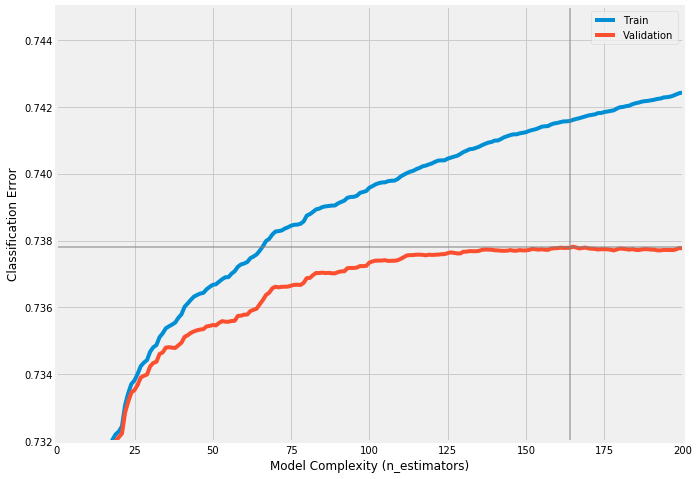

In [12]:
# Graph our new train/validation curves

# Get evaluation results from model
results = model.evals_result()

# Get train error
train_error = results['validation_0']['auc']
# Get validation error
val_error = results['validation_1']['auc']
# Set epoch
epoch = range(1, len(train_error)+1)

plt.figure(figsize=(10,8))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim(0.732, 0.745)   # Zoom in
plt.xlim(0, 200)         # Squish x-axis
plt.axvline(x=164,       # Draw vertical line through n_estimators that gives best ROC AUC Score
            color='gray', 
            alpha=0.5,
            linewidth=2) 
plt.axhline(y=0.737818,  # Draw horizontal line through error that gives best ROC AUC Score
            color='gray',
            alpha=0.5,
            linewidth=2)
plt.legend();

In [13]:
# Let's get the metrics for our model
from sklearn.metrics import classification_report

# Get predictions for our validation set
y_pred  = model.predict(X_val_encoded)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

      Female       0.70      0.62      0.66     55166
        Male       0.67      0.74      0.70     56834

    accuracy                           0.68    112000
   macro avg       0.69      0.68      0.68    112000
weighted avg       0.69      0.68      0.68    112000



In [14]:
# Get ROC AUC score
from sklearn.metrics import roc_auc_score, roc_curve

# Get ROC AUC score for the model
y_pred_proba = model.predict_proba(X_val_encoded)[:,1]
roc_auc_score(y_val, y_pred_proba)  # Should equal ~0.7382 IAW the model we ran earlier

0.737818456968959

In [15]:
# Define function to plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    
    # Get label names from y target vector
    labels = unique_labels(y_true)
    
    # Set column labels for confusion matrix
    columns = [f'Predicted {label}' for label in labels]
    # Set index labels for confusion matrix
    index = [f'Actual {label}' for label in labels]
    
    # Create pandas dataframe to store info prior to plotting
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    
    return sns.heatmap(table, annot=True, fmt='d', cmap='YlGnBu')

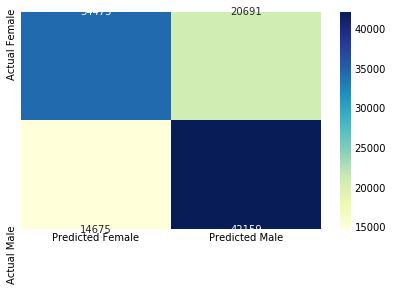

In [16]:
plot_confusion_matrix(y_val, y_pred);

In [17]:
# Visualize the ROC AUC Curve
from ipywidgets import interact, fixed, interactive
from IPython.display import display
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

widget = interactive(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0.0,1.0,0.05))

display(widget)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [18]:
# Define function that pulls encoder mappings for the feature we specify
def feature_mapping(feature):
    for item in encoder.mapping:
        if item['col'] == feature:
            feature_mapping = item['mapping']
            
    feature_map = feature_mapping[feature_mapping.index.dropna()]
    category_names = feature_mapping.index.tolist()
    category_codes = feature_mapping.values.tolist()
    
    return (feature_map, category_names, category_codes)

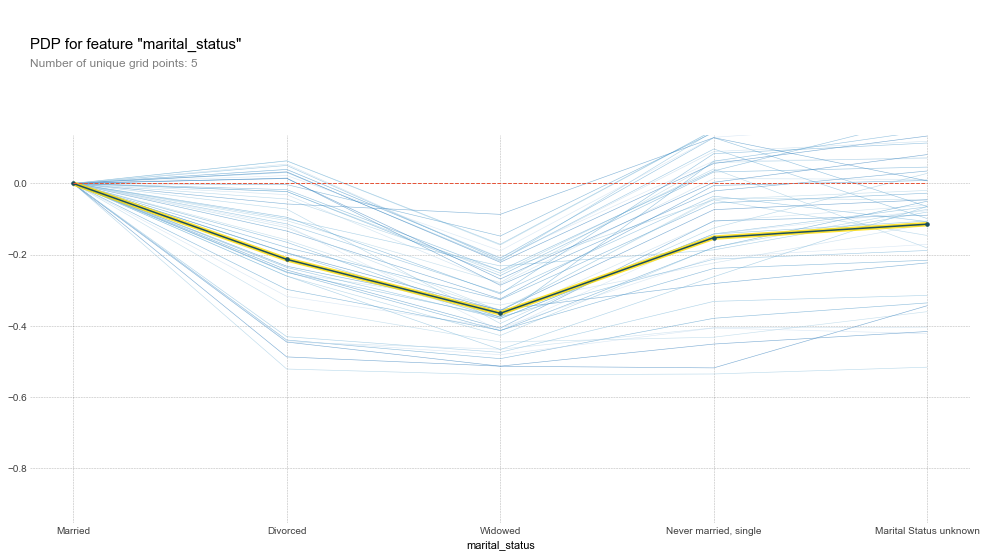

In [19]:
# Let's look at how marital_status affects the model
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'marital_status'

feat_map, names, codes = feature_mapping(feature)

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=50);
# Change the xticks labels
plt.xticks([1, 2, 3, 4, 5], names);

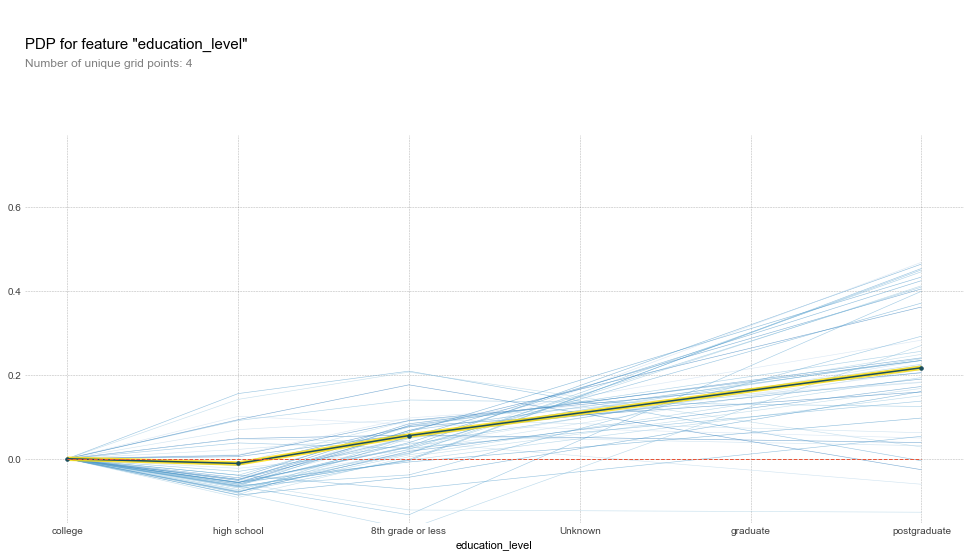

In [21]:
# Let's look at how education_level affects the model
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'education_level'

feat_map, names, codes = feature_mapping(feature)

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=50);
# Change the xticks labels
plt.xticks([1,2,3,4,5,6], names);

In [22]:
# Look at marital status compared to education level
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Define function that takes any 2 features and returns an interactive PDP
def interactive_plot(a, b):
    # Assign inputs as features
    features = [a, b]   
    

    # Build interaction model
    interaction = pdp_interact(
        model=model,
        dataset=X_val_encoded, 
        model_features=X_val_encoded.columns, 
        features=features
    )

    # Create pivot table
    pdp = interaction.pdp.pivot_table(
        values='preds',
        columns=features[0],
        index=features[1]
    )

    # Get names and codes from encoder.mapping
    _, a_names, a_codes = feature_mapping(features[0])
    _, b_names, b_codes = feature_mapping(features[1])

    # Add column & index names to pivot table
    pdp = pdp.rename(index=dict(zip(b_codes, b_names)),
                     columns=dict(zip(a_codes, a_names)))


    # Set plot's figure size
    plt.figure(figsize=(10,8))
    return sns.heatmap(pdp, annot=True, fmt='.2f', cmap='YlGnBu');

In [23]:
# Interactive widget based on top categorical features as determined by permutation importance
# test run earlier
interactive_widget = interactive(
    interactive_plot,
    a=['marital_status', 'education_level', 'place_of_death_and_decedents_status', 'race', 'method_of_disposition'],
    b=['marital_status', 'education_level', 'place_of_death_and_decedents_status', 'race', 'method_of_disposition']
)

display(interactive_widget)

interactive(children=(Dropdown(description='a', options=('marital_status', 'education_level', 'place_of_death_…

In [24]:
# The model looks good!
# How does it do on the test data?
X_test_encoded = encoder.transform(X_test)
test_pred_proba = model.predict_proba(X_test_encoded)[:,1]
roc_auc_score(y_test, test_pred_proba)

0.7381663733777781

In [25]:
# Define a function where the user puts in some arguments and the computer
# predicts whether it's a male or female
import shap

def create_dataframe():
    df = pd.DataFrame(
        data=[[X_train['resident_status'].mode()[0], 
              X_train['month_of_death'].mode()[0],
              0,
              X_train['place_of_death_and_decedents_status'].mode()[0], 
              0,
              X_train['injury_at_work'].mode()[0],
              X_train['manner_of_death'].mode()[0], 
              X_train['method_of_disposition'].mode()[0],
              X_train['autopsy'].mode()[0],
              X_train['activity_code'].mode()[0],
              0,
              X_train['hispanic_origin'].mode()[0],
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        columns=['resident_status', 'month_of_death', 'detail_age', 'place_of_death_and_decedents_status', 
                 'marital_status', 'injury_at_work', 'manner_of_death', 'method_of_disposition', 'autopsy', 
                 'activity_code', 'race', 'hispanic_origin', 'education_level', 'heart_disease', 'cancer', 
                 'hiv', 'suicide', 'homicide', 'accident', 'alzheimers', 'respiratory', 'diabetes']
    )
    
    return df


def predict(age, marital_status, education_level, race, cause_of_death):
    
    # Create dataframe
    df = create_dataframe()
    
    # Store input data in dataframe
    df['detail_age'] = age
    df['marital_status'] = marital_status
    df['education_level'] = education_level
    df['race'] = race
    
    # Assign 1 to column for cause_of_death, else 0
    if cause_of_death in df.columns:
        df[cause_of_death] = 1
    
    # Encode the dataframe
    X_encoded = encoder.transform(df)
    
    
    # Assign positive class and index number
    positive_class = 'Male'
    positive_class_index = 1 
    
    # Call model for prediction
    pred = model.predict(X_encoded)
    predict = pred[0]
    
    # Get predicted probability
    pred_proba = model.predict_proba(X_encoded)[0,positive_class_index]
    
    probability = pred_proba * 100
    if pred != positive_class:
        probability = 100 - probability
    
    # Show prediction and probability
    result = f'Gender is {probability:.0f}% likely to be {predict}\n'
    print(result)

In [26]:
new_widget = interactive(predict, 
         age=(0,150,1), 
         marital_status=['Married', 'Divorced', 'Widowed', 'Never married, single', 'Marital status unknown'],
         education_level=['8th grade or less', 'high school', 'college', 'graduate', 'postgraduate', 'unknown'],
         race=['White', 'Black', 'Other Asian or Pacific Islander in areas reporting codes 18-58', 
               'Vietnamese', 'American Indian (includes Aleuts and Eskimos)', 'Filipino', 'Chinese', 
               'Japanese', 'Combined other Asian or Pacific Islander, includes codes 18-68', 'Asian Indian', 
               'Korean', 'Samoan', 'Guamanian', 'Hawaiian (includes Part-Hawaiian)'],
         cause_of_death=['heart_disease', 'cancer', 'hiv', 'suicide', 'homicide', 'accident', 
                         'alzheimers', 'respiratory', 'diabetes', 'none'],
)

display(new_widget)

interactive(children=(IntSlider(value=75, description='age', max=150), Dropdown(description='marital_status', …

In [27]:
# Define explainer function to show shapley values for our test data
def explainer(row_number):
    
    positive_class = 'Male'
    positive_class_index = 1
    
    # Get & process the data for the row
    row = X_test.loc[[row_number]]
    row_processed = encoder.transform(row)
    
     # Call model for prediction
    pred = model.predict(row_processed)
    predict = pred[0]
    
    # Get predicted probability
    pred_proba = model.predict_proba(row_processed)[0,positive_class_index]
    probability = pred_proba * 100
    if pred != positive_class:
        probability = 100 - probability
    
    # Show prediction and probability
    result = f'Gender is {probability:.0f}% likely to be {predict}\n'
    print(result)
    
    # Get SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row_processed)
    
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values,
        features=row
    )

In [28]:
df = pd.DataFrame({
    'true': y_test,
    'predicted': test_pred_proba
                  }
)

male = y_test == 'Male'
female = ~male
right = (male) == (df['predicted'] > 0.50)
wrong = ~right


df[female & right].sample(n=10, random_state=1).sort_values(by='predicted')

,true,predicted
632861,Female,0.142612
599918,Female,0.172343
383432,Female,0.179142
212935,Female,0.269816
363764,Female,0.316943
281488,Female,0.317325
452008,Female,0.320737
310448,Female,0.358462
120259,Female,0.364123
690239,Female,0.411070


In [29]:
explainer(690239)

Gender is 59% likely to be Female



In [34]:
import plotly.express as px
length = len(test['sex'])
fig = px.bar(test, x="sex", y=[length], color='marital_status', barmode='group',
             height=400)
fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['resident_status', 'month_of_death', 'sex', 'detail_age_type', 'detail_age', 'infant_age_recode_22', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death', 'method_of_disposition', 'autopsy', 'activity_code', 'race', 'hispanic_origin', 'education_level', 'heart_disease', 'cancer', 'hiv', 'suicide', 'homicide', 'accident', 'alzheimers', 'respiratory', 'diabetes'] but received: [700000]

In [41]:
ct = pd.crosstab(test['sex'], test['marital_status'], normalize='index') * 100
ct

marital_status,Divorced,Marital Status unknown,Married,"Never married, single",Widowed
sex,,,,,
Female,14.966385,0.431282,24.583365,9.942689,50.076279
Male,16.093116,1.049227,48.869977,15.795549,18.192132


In [44]:
import plotly.graph_objects as go
sex = ['Male', 'Female']

fig = go.Figure(data=[
    go.Bar(name='Married', x=sex, y=[ct.loc['Male','Married'], ct.loc['Female','Married']]),
    go.Bar(name='Divorced', x=sex, y=[ct.loc['Male','Divorced'], ct.loc['Female','Divorced']]),
    go.Bar(name='Widowed', x=sex, y=[ct.loc['Male','Widowed'], ct.loc['Female','Widowed']]),
    go.Bar(name='Never Married, single', x=sex, y=[ct.loc['Male','Never married, single'], 
                                                   ct.loc['Female','Never married, single']]),
    go.Bar(name='Marital Status unknown', x=sex, y=[ct.loc['Male','Marital Status unknown'], 
                                                    ct.loc['Female','Marital Status unknown']])
])
# Change the bar mode
fig.update_layout(barmode='stack', title_text='Proportion of Decedent Marital Statuses by Gender (%)')
fig.show()

In [9]:
test.to_csv('cleaned_df.csv')

In [46]:
!pwd

/Users/nickburkhalter/Desktop/Lambda School/Unit 2/mortality_dash_template


In [47]:
len(X_train.columns), len(test.columns)

(22, 26)

In [48]:
X_train.columns

Index(['resident_status', 'month_of_death', 'detail_age', 'place_of_death_and_decedents_status', 'marital_status', 'injury_at_work', 'manner_of_death', 'method_of_disposition', 'autopsy', 'activity_code', 'race', 'hispanic_origin', 'education_level', 'heart_disease', 'cancer', 'hiv', 'suicide', 'homicide', 'accident', 'alzheimers', 'respiratory', 'diabetes'], dtype='object')